In [2]:
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms, utils
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
#import wandb
from torch_fidelity import calculate_metrics
import shutil


In [3]:


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#wandb.login()
#wandb.init(project="cgan_project", entity="nidhi_soni")

# Data directories and CSV file path
SKETCH_DIR = '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/SKetchs'
IMAGE_DIR = '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/Real_Images'
CSV_PATH = '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/label_nw.csv'

# Load labels
labels_df = pd.read_csv(CSV_PATH)
labels = np.argmax(labels_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values, axis=1)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [4]:

# Custom dataset class for unpaired sketches and images
class CustomDataset(Dataset):
    def __init__(self, sketch_dir, image_dir, labels, transform=None):
        self.sketch_files = sorted([os.path.join(sketch_dir, f) for f in os.listdir(sketch_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return min(len(self.sketch_files), len(self.labels))

    def __getitem__(self, idx):
        sketch = Image.open(self.sketch_files[idx]).convert('RGB')
        random_image_idx = random.randint(0, len(self.image_files) - 1)  # Random image index for unpaired setup
        image = Image.open(self.image_files[random_image_idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            sketch = self.transform(sketch)
            image = self.transform(image)

        return sketch, image, label



In [5]:

# Load dataset and create dataloader
dataset = CustomDataset(SKETCH_DIR, IMAGE_DIR, labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(7, 50)
        self.init_size = 64 // 4
        self.l1 = nn.Sequential(nn.Linear(100 + 50, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [7]:

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(7, 50)
        self.model = nn.Sequential(
            nn.Linear(3*64*64 + 50, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


In [8]:

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()


In [9]:

def denormalize(tensors):
    tensors = tensors * 0.5 + 0.5  # convert tensor to [0,1]
    return tensors


Epoch [1/10], Batch [1/256], D loss: 0.31750136613845825, G loss: 1.1720545291900635
Epoch [1/10], Batch [2/256], D loss: 0.3437960743904114, G loss: 1.6229829788208008
Epoch [1/10], Batch [3/256], D loss: 0.39678657054901123, G loss: 1.2024967670440674
Epoch [1/10], Batch [4/256], D loss: 0.3408271074295044, G loss: 1.4281151294708252
Epoch [1/10], Batch [5/256], D loss: 0.46897369623184204, G loss: 1.1011029481887817
Epoch [1/10], Batch [6/256], D loss: 0.483942449092865, G loss: 1.3537027835845947
Epoch [1/10], Batch [7/256], D loss: 0.39886385202407837, G loss: 1.491929292678833
Epoch [1/10], Batch [8/256], D loss: 0.45134425163269043, G loss: 0.9519544243812561
Epoch [1/10], Batch [9/256], D loss: 0.33062320947647095, G loss: 2.773585796356201
Epoch [1/10], Batch [10/256], D loss: 0.3288358449935913, G loss: 1.4851577281951904
Epoch [1/10], Batch [11/256], D loss: 0.35907885432243347, G loss: 1.2963025569915771
Epoch [1/10], Batch [12/256], D loss: 0.43591874837875366, G loss: 2.5

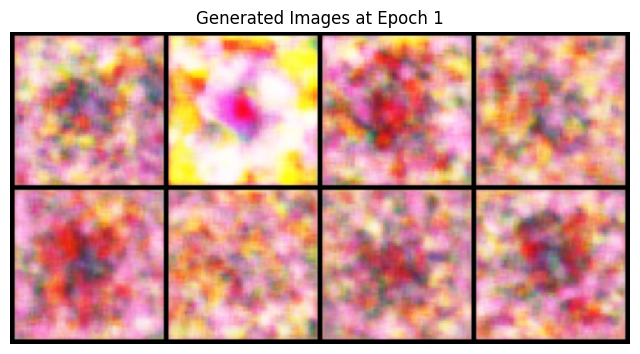

Epoch [2/10], Batch [1/256], D loss: 0.582709550857544, G loss: 1.0625112056732178
Epoch [2/10], Batch [2/256], D loss: 0.43641555309295654, G loss: 1.5184426307678223
Epoch [2/10], Batch [3/256], D loss: 0.42887693643569946, G loss: 2.0965001583099365
Epoch [2/10], Batch [4/256], D loss: 0.33476486802101135, G loss: 1.5688725709915161
Epoch [2/10], Batch [5/256], D loss: 0.2930896282196045, G loss: 1.6084367036819458
Epoch [2/10], Batch [6/256], D loss: 0.25882989168167114, G loss: 2.1086974143981934
Epoch [2/10], Batch [7/256], D loss: 0.3194486200809479, G loss: 1.649256944656372
Epoch [2/10], Batch [8/256], D loss: 0.4438486695289612, G loss: 1.0758256912231445
Epoch [2/10], Batch [9/256], D loss: 0.35980063676834106, G loss: 1.7800500392913818
Epoch [2/10], Batch [10/256], D loss: 0.4863077998161316, G loss: 0.8378283977508545
Epoch [2/10], Batch [11/256], D loss: 0.48439085483551025, G loss: 2.106623411178589
Epoch [2/10], Batch [12/256], D loss: 0.4696785807609558, G loss: 1.293

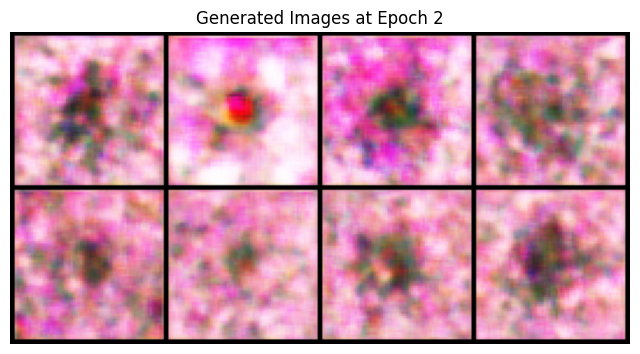

Epoch [3/10], Batch [1/256], D loss: 0.4741792678833008, G loss: 3.5808255672454834
Epoch [3/10], Batch [2/256], D loss: 0.3741236627101898, G loss: 1.1884450912475586
Epoch [3/10], Batch [3/256], D loss: 0.4131534695625305, G loss: 1.0151000022888184
Epoch [3/10], Batch [4/256], D loss: 0.461719274520874, G loss: 2.112027883529663
Epoch [3/10], Batch [5/256], D loss: 0.5029493570327759, G loss: 0.8127292394638062
Epoch [3/10], Batch [6/256], D loss: 0.5646682381629944, G loss: 2.3208250999450684
Epoch [3/10], Batch [7/256], D loss: 0.6591437458992004, G loss: 0.5404587984085083
Epoch [3/10], Batch [8/256], D loss: 0.5455336570739746, G loss: 3.183260917663574
Epoch [3/10], Batch [9/256], D loss: 0.4441278576850891, G loss: 1.9276766777038574
Epoch [3/10], Batch [10/256], D loss: 0.5767472982406616, G loss: 0.6808151006698608
Epoch [3/10], Batch [11/256], D loss: 0.5273232460021973, G loss: 2.0463361740112305
Epoch [3/10], Batch [12/256], D loss: 0.56950443983078, G loss: 1.92537474632

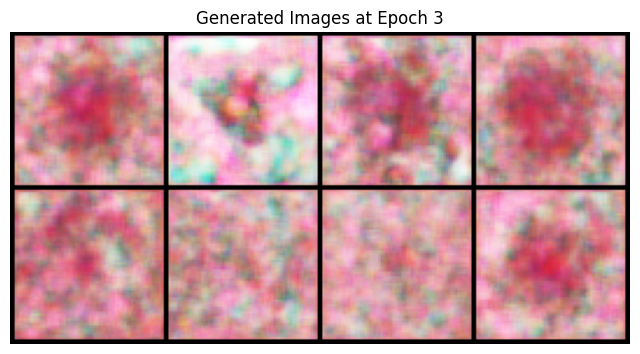

Epoch [4/10], Batch [1/256], D loss: 1.0597695112228394, G loss: 3.00126314163208
Epoch [4/10], Batch [2/256], D loss: 1.12284255027771, G loss: 0.3435276746749878
Epoch [4/10], Batch [3/256], D loss: 1.068703293800354, G loss: 1.6917141675949097
Epoch [4/10], Batch [4/256], D loss: 0.995032787322998, G loss: 0.8256586790084839
Epoch [4/10], Batch [5/256], D loss: 0.6490939259529114, G loss: 0.8585183620452881
Epoch [4/10], Batch [6/256], D loss: 0.38600313663482666, G loss: 1.602918267250061
Epoch [4/10], Batch [7/256], D loss: 0.42012858390808105, G loss: 1.6376252174377441
Epoch [4/10], Batch [8/256], D loss: 0.29002270102500916, G loss: 1.5485421419143677
Epoch [4/10], Batch [9/256], D loss: 0.47228437662124634, G loss: 1.3401583433151245
Epoch [4/10], Batch [10/256], D loss: 0.3843209147453308, G loss: 1.440078616142273
Epoch [4/10], Batch [11/256], D loss: 0.40574437379837036, G loss: 1.439929485321045
Epoch [4/10], Batch [12/256], D loss: 0.36441588401794434, G loss: 1.390325784

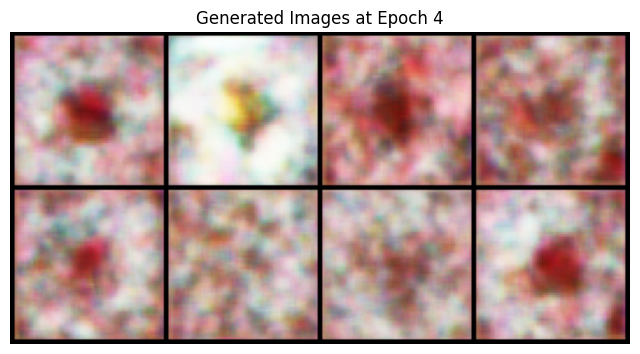

Epoch [5/10], Batch [1/256], D loss: 0.4687819182872772, G loss: 1.487830400466919
Epoch [5/10], Batch [2/256], D loss: 0.32703977823257446, G loss: 1.2426114082336426
Epoch [5/10], Batch [3/256], D loss: 0.4311484098434448, G loss: 1.655737042427063
Epoch [5/10], Batch [4/256], D loss: 0.3981655240058899, G loss: 1.5304958820343018
Epoch [5/10], Batch [5/256], D loss: 0.33617156744003296, G loss: 1.6066464185714722
Epoch [5/10], Batch [6/256], D loss: 0.45148590207099915, G loss: 1.426536202430725
Epoch [5/10], Batch [7/256], D loss: 0.4213207960128784, G loss: 0.8797524571418762
Epoch [5/10], Batch [8/256], D loss: 0.5073168277740479, G loss: 2.2190499305725098
Epoch [5/10], Batch [9/256], D loss: 0.5937712788581848, G loss: 0.816128134727478
Epoch [5/10], Batch [10/256], D loss: 0.5386940836906433, G loss: 0.9133256077766418
Epoch [5/10], Batch [11/256], D loss: 0.6238305568695068, G loss: 1.7525361776351929
Epoch [5/10], Batch [12/256], D loss: 0.523353099822998, G loss: 0.71654009

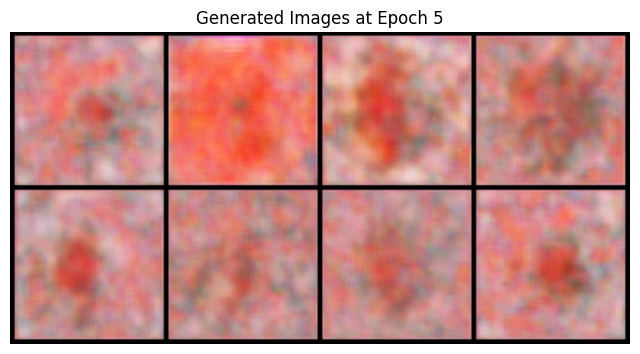

Epoch [6/10], Batch [1/256], D loss: 0.5152561068534851, G loss: 0.8684726357460022
Epoch [6/10], Batch [2/256], D loss: 0.46352702379226685, G loss: 0.940247654914856
Epoch [6/10], Batch [3/256], D loss: 0.8670454621315002, G loss: 2.035194158554077
Epoch [6/10], Batch [4/256], D loss: 0.9797425270080566, G loss: 0.2791156470775604
Epoch [6/10], Batch [5/256], D loss: 0.8469226360321045, G loss: 1.862095594406128
Epoch [6/10], Batch [6/256], D loss: 0.5391932725906372, G loss: 1.6023948192596436
Epoch [6/10], Batch [7/256], D loss: 0.564727783203125, G loss: 1.1597850322723389
Epoch [6/10], Batch [8/256], D loss: 0.462507426738739, G loss: 1.370377779006958
Epoch [6/10], Batch [9/256], D loss: 0.45305484533309937, G loss: 1.2299683094024658
Epoch [6/10], Batch [10/256], D loss: 0.4289592206478119, G loss: 0.9272891283035278
Epoch [6/10], Batch [11/256], D loss: 0.43654078245162964, G loss: 1.142798900604248
Epoch [6/10], Batch [12/256], D loss: 0.525883138179779, G loss: 1.17893886566

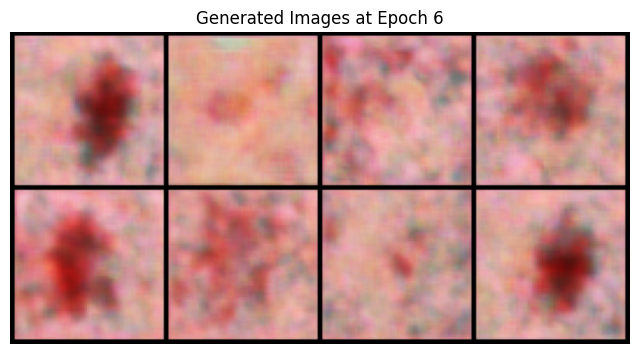

Epoch [7/10], Batch [1/256], D loss: 0.4864647686481476, G loss: 1.234137773513794
Epoch [7/10], Batch [2/256], D loss: 0.6555212736129761, G loss: 1.3432961702346802
Epoch [7/10], Batch [3/256], D loss: 0.7060193419456482, G loss: 0.4134190082550049
Epoch [7/10], Batch [4/256], D loss: 0.5575217604637146, G loss: 2.013087511062622
Epoch [7/10], Batch [5/256], D loss: 0.5342724323272705, G loss: 0.948534369468689
Epoch [7/10], Batch [6/256], D loss: 0.4852312207221985, G loss: 0.9658801555633545
Epoch [7/10], Batch [7/256], D loss: 0.43246790766716003, G loss: 1.4890365600585938
Epoch [7/10], Batch [8/256], D loss: 0.6385560631752014, G loss: 1.180471658706665
Epoch [7/10], Batch [9/256], D loss: 0.6831482648849487, G loss: 0.6244698762893677
Epoch [7/10], Batch [10/256], D loss: 0.5081340074539185, G loss: 1.10569429397583
Epoch [7/10], Batch [11/256], D loss: 0.4969134032726288, G loss: 1.1393442153930664
Epoch [7/10], Batch [12/256], D loss: 0.5579484701156616, G loss: 1.33854734897

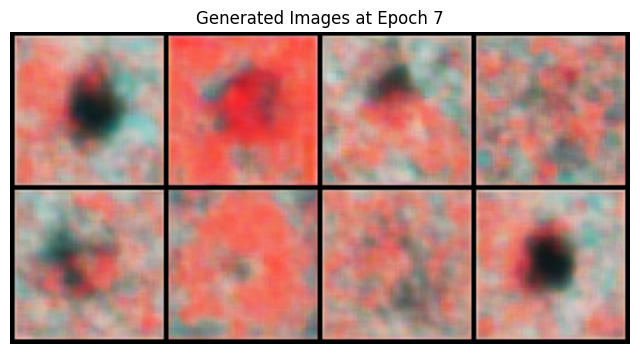

Epoch [8/10], Batch [1/256], D loss: 0.49748897552490234, G loss: 0.8588387966156006
Epoch [8/10], Batch [2/256], D loss: 0.521068811416626, G loss: 1.008410930633545
Epoch [8/10], Batch [3/256], D loss: 0.4592582583427429, G loss: 1.6825714111328125
Epoch [8/10], Batch [4/256], D loss: 0.5569788813591003, G loss: 0.7432090044021606
Epoch [8/10], Batch [5/256], D loss: 0.5745684504508972, G loss: 1.488079309463501
Epoch [8/10], Batch [6/256], D loss: 0.6115480661392212, G loss: 1.3541440963745117
Epoch [8/10], Batch [7/256], D loss: 0.5251290798187256, G loss: 0.7186762094497681
Epoch [8/10], Batch [8/256], D loss: 0.7049179077148438, G loss: 1.8502637147903442
Epoch [8/10], Batch [9/256], D loss: 0.6665762662887573, G loss: 0.6476727724075317
Epoch [8/10], Batch [10/256], D loss: 0.42667222023010254, G loss: 1.4976457357406616
Epoch [8/10], Batch [11/256], D loss: 0.49714261293411255, G loss: 1.8707845211029053
Epoch [8/10], Batch [12/256], D loss: 0.6560772061347961, G loss: 0.499364

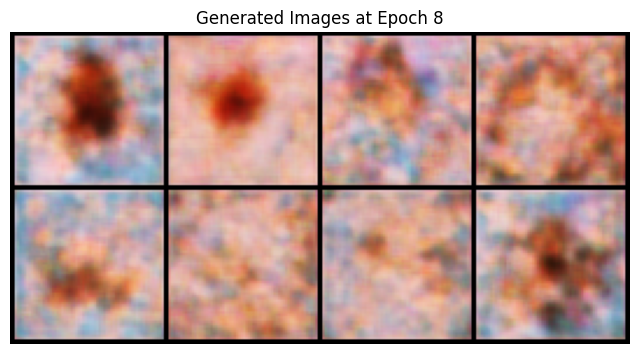

Epoch [9/10], Batch [1/256], D loss: 0.5162856578826904, G loss: 1.3357417583465576
Epoch [9/10], Batch [2/256], D loss: 0.48751300573349, G loss: 0.8919894695281982
Epoch [9/10], Batch [3/256], D loss: 0.5652126669883728, G loss: 1.636385202407837
Epoch [9/10], Batch [4/256], D loss: 0.640346348285675, G loss: 0.6331298351287842
Epoch [9/10], Batch [5/256], D loss: 0.5539939999580383, G loss: 1.8739631175994873
Epoch [9/10], Batch [6/256], D loss: 0.535849928855896, G loss: 1.042468786239624
Epoch [9/10], Batch [7/256], D loss: 0.6626178622245789, G loss: 0.8030789494514465
Epoch [9/10], Batch [8/256], D loss: 0.5808193683624268, G loss: 1.211393117904663
Epoch [9/10], Batch [9/256], D loss: 0.5080603957176208, G loss: 0.8677520751953125
Epoch [9/10], Batch [10/256], D loss: 0.4054858684539795, G loss: 1.918353796005249
Epoch [9/10], Batch [11/256], D loss: 0.3392076790332794, G loss: 1.4217157363891602
Epoch [9/10], Batch [12/256], D loss: 0.440579891204834, G loss: 0.979706764221191

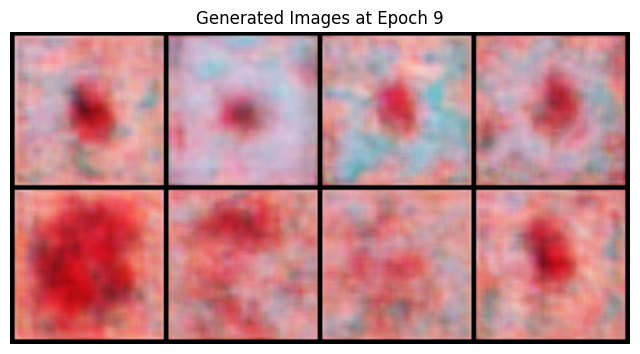

Epoch [10/10], Batch [1/256], D loss: 0.6855701208114624, G loss: 0.9721260070800781
Epoch [10/10], Batch [2/256], D loss: 0.7027101516723633, G loss: 1.1787683963775635
Epoch [10/10], Batch [3/256], D loss: 0.6664385199546814, G loss: 0.6520166397094727
Epoch [10/10], Batch [4/256], D loss: 0.5389165878295898, G loss: 1.1306594610214233
Epoch [10/10], Batch [5/256], D loss: 0.49978333711624146, G loss: 1.1739253997802734
Epoch [10/10], Batch [6/256], D loss: 0.5429762601852417, G loss: 1.2215499877929688
Epoch [10/10], Batch [7/256], D loss: 0.6325044631958008, G loss: 0.5878888964653015
Epoch [10/10], Batch [8/256], D loss: 0.5755663514137268, G loss: 1.1363437175750732
Epoch [10/10], Batch [9/256], D loss: 0.5605628490447998, G loss: 0.9515400528907776
Epoch [10/10], Batch [10/256], D loss: 0.551443338394165, G loss: 0.7651733160018921
Epoch [10/10], Batch [11/256], D loss: 0.6494659185409546, G loss: 0.9184736609458923
Epoch [10/10], Batch [12/256], D loss: 0.6338003873825073, G lo

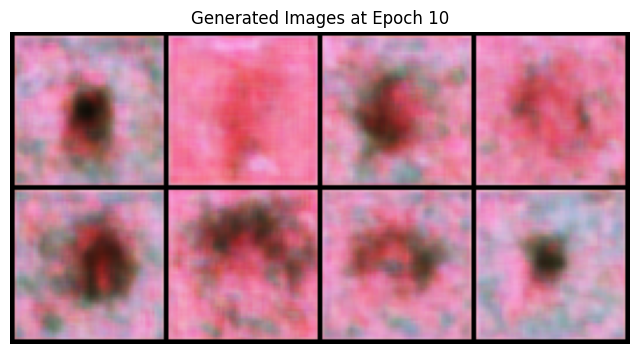

In [12]:

for epoch in range(10):  # Adjust number of epochs as needed
    for i, (sketches, real_imgs, labels) in enumerate(dataloader):
        valid = torch.ones((real_imgs.size(0), 1), device=device)
        fake = torch.zeros((real_imgs.size(0), 1), device=device)

        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(real_imgs.size(0), 100, device=device)
        gen_imgs = generator(z, labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        print(f"Epoch [{epoch+1}/10], Batch [{i+1}/{len(dataloader)}], D loss: {d_loss.item()}, G loss: {g_loss.item()}")

        # Visualization at the end of each epoch
        if i == len(dataloader) - 1:
            with torch.no_grad():
                fixed_z = torch.randn(8, 100, device=device)  # Fixed noise for consistency in visualization
                fixed_labels = torch.tensor([j % 7 for j in range(8)], dtype=torch.long, device=device)
                generated_images = generator(fixed_z, fixed_labels)
                generated_images = denormalize(generated_images)
                grid = torchvision.utils.make_grid(generated_images, nrow=4).permute(1, 2, 0).cpu().numpy()
                plt.figure(figsize=(8, 8))
                plt.imshow(grid)
                plt.axis('off')
                plt.title(f'Generated Images at Epoch {epoch + 1}')
                plt.show()


In [25]:
# Save models for Future 
torch.save(generator.state_dict(), 'my_generator.pth')
torch.save(discriminator.state_dict(), 'my_discriminator.pth')

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

generator = Generator().to(device)
generator.load_state_dict(torch.load('/home/planck/Ravi_Saxena/Python_Codes/ML&DL/my_generator.pth', map_location=device))
generator.eval()


Generator(
  (label_emb): Embedding(7, 50)
  (l1): Sequential(
    (0): Linear(in_features=150, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [27]:

# Function to preprocess sketches
def preprocess_sketch(sketch_path):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  
    ])
    sketch_image = Image.open(sketch_path).convert('RGB')
    return transform(sketch_image).unsqueeze(0)  

# Sketches to process
sketch_paths = [
    '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/new_sktch/Sketch_38.png',
    '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/new_sktch/Sketch_39.png',
    '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/new_sktch/Sketch_49.png'
]


In [28]:

generated_images = []
for sketch_path in sketch_paths:
    preprocessed_sketch = preprocess_sketch(sketch_path).to(device)
   
    with torch.no_grad():
       
        z = torch.randn(preprocessed_sketch.size(0), 100, device=device)
   
        labels = torch.randint(0, 7, (preprocessed_sketch.size(0),), device=device)
        generated_image = generator(z, labels)
       
    
    generated_images.append(generated_image.cpu())


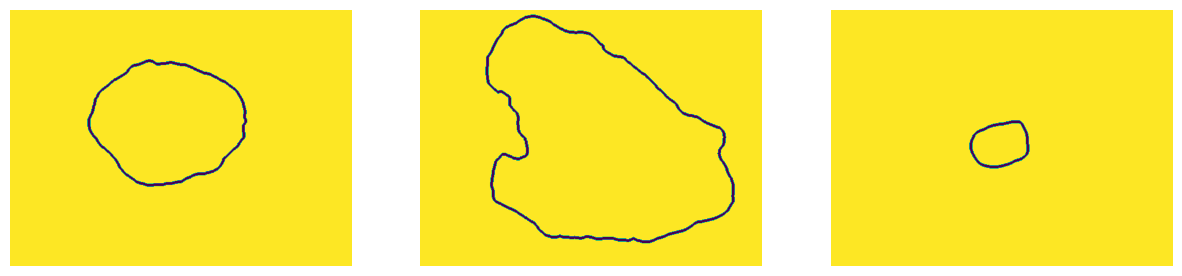

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


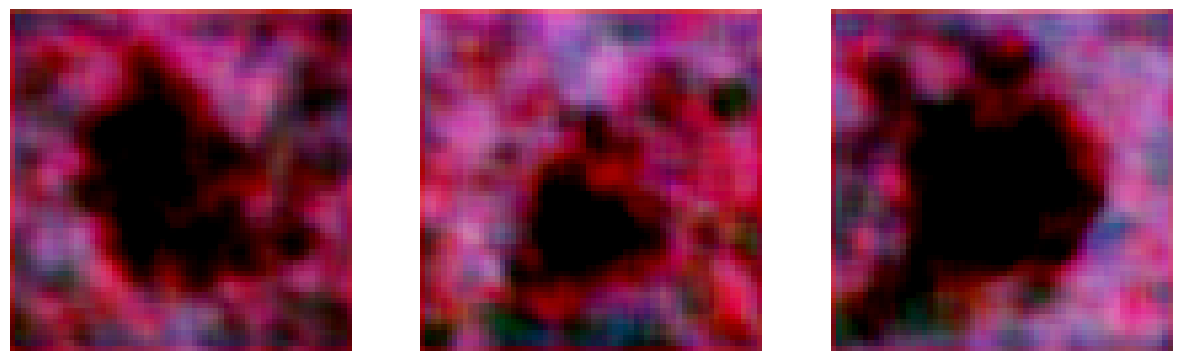

In [29]:
# Path to the folder containing images
folder_path = '/home/planck/Ravi_Saxena/Python_Codes/ML&DL/DL_Ass_4/new_sktch'

# List all files in the folder
files = os.listdir(folder_path)

image_files = [file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]
fig, axes = plt.subplots(nrows=1, ncols=len(image_files), figsize=(15, 15))
for ax, image_file in zip(axes, image_files):
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()




# Display generated images
fig, axes = plt.subplots(nrows=1, ncols=len(generated_images), figsize=(15, 15))
for ax, img in zip(axes, generated_images):
    ax.axis('off')
    ax.imshow(make_grid(img, nrow=1).permute(1, 2, 0).numpy())

plt.show()



